In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import optuna 

/home/ahmad/ml_project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("Life_Expectancy_Data.csv")


# Removing NaN Values
print(f"Original rows: {len(df)}")
df = df.dropna(subset=["Life expectancy "]) # dropping rows with no target value
print(f"After dropping NaN targets: {len(df)}")

Original rows: 2938
After dropping NaN targets: 2928


In [3]:
X = df.drop(columns=["Life expectancy ", "Status"])
y = df["Life expectancy "] 


In [4]:
print(df.columns)

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')


In [5]:
from sklearn.preprocessing import LabelEncoder

# Drop Status and target columns
X = df.drop(columns=["Life expectancy ", "Status"])

# Impute NaN in features FIRST
imputer = SimpleImputer(strategy='mean')
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
X[numeric_cols] = imputer.fit_transform(X[numeric_cols])

# Encode Country as numeric values
le = LabelEncoder()
X['Country'] = le.fit_transform(X['Country'])

# Normalization
scaler = StandardScaler()
X = scaler.fit_transform(X)

y_scaler = StandardScaler()
y = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:
# Converting from numpy arrays to pytorch tensors

X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train).reshape(-1, 1)
y_val = torch.FloatTensor(y_val).reshape(-1, 1)
y_test = torch.FloatTensor(y_test).reshape(-1, 1)

In [8]:
class MLPRegressor(nn.Module):
    def __init__(self, hidden_sizes, dropout_rate):
        super().__init__()

        self.layers = nn.ModuleList()

        input_size = 20

        for hidden_size in hidden_sizes: # iterate through hidden layer sizes
            block = nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            )

            self.layers.append(block) # add block layer to the complete layers list
            input_size = hidden_size

        self.layers.append(nn.Linear(input_size, 1))

    def forward(self, x):

        for layer in self.layers: # passing through the layers
            x = layer(x)

        return x

In [9]:
def initialize_model_and_train(hidden_sizes, dropout_rate, lr=0.001, epochs=250):

    model = MLPRegressor(hidden_sizes, dropout_rate)
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_rmse_history = []
    val_rmse_history = []

    # Training loop
    for epoch in range(epochs):
        model.train() # setting the model to the training mode
        optimizer.zero_grad()
        
        output = model(X_train)
        loss = loss_function(output, y_train) # calculating the loss
        loss.backward() # calculating the backward pass
        optimizer.step() # updating the weights

        train_rmse = torch.sqrt(loss).item()
        train_rmse_history.append(train_rmse)

        # Validation
        model.eval() # setting the model to the validation mode
        with torch.no_grad():
            output = model(X_val)
            val_loss = loss_function(output, y_val)
            val_rmse = torch.sqrt(val_loss).item()
            val_rmse_history.append(val_rmse)

        if epoch % 10 == 0: # prints every 10 epochs
            print(f"Epoch {epoch}: train_loss={loss.item():.4f}, val_loss={val_loss.item():.4f}")

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        
        mse = loss_function(y_pred, y_test).item()
        rmse = torch.sqrt(torch.tensor(mse)).item()
        
        # R^2 score
        ss_res = torch.sum((y_test - y_pred) ** 2).item()
        ss_tot = torch.sum((y_test - torch.mean(y_test)) ** 2).item()
        r2 = 1 - (ss_res / ss_tot)

    print(f"Test MSE: {mse:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test R²: {r2:.4f}")
        
    return train_rmse_history, val_rmse_history

hidden_sizes=[16, 8, 4]
dropout_rate = 0.1
train_rmse_history, val_rmse_history = initialize_model_and_train(hidden_sizes, dropout_rate)

Epoch 0: train_loss=1.1706, val_loss=1.1782
Epoch 10: train_loss=1.1142, val_loss=1.1207
Epoch 20: train_loss=1.0521, val_loss=1.0549
Epoch 30: train_loss=0.9693, val_loss=0.9689
Epoch 40: train_loss=0.8638, val_loss=0.8581
Epoch 50: train_loss=0.7464, val_loss=0.7284
Epoch 60: train_loss=0.6387, val_loss=0.6148
Epoch 70: train_loss=0.5836, val_loss=0.5579
Epoch 80: train_loss=0.5712, val_loss=0.5263
Epoch 90: train_loss=0.5267, val_loss=0.4975
Epoch 100: train_loss=0.5121, val_loss=0.4727
Epoch 110: train_loss=0.4895, val_loss=0.4457
Epoch 120: train_loss=0.4652, val_loss=0.4183
Epoch 130: train_loss=0.4355, val_loss=0.3911
Epoch 140: train_loss=0.4197, val_loss=0.3624
Epoch 150: train_loss=0.4101, val_loss=0.3322
Epoch 160: train_loss=0.3751, val_loss=0.3015
Epoch 170: train_loss=0.3503, val_loss=0.2736
Epoch 180: train_loss=0.3262, val_loss=0.2496
Epoch 190: train_loss=0.2991, val_loss=0.2281
Epoch 200: train_loss=0.3017, val_loss=0.2089
Epoch 210: train_loss=0.2762, val_loss=0.1937

In [10]:
print(f"Final train RMSE: {train_rmse_history[-1]:.4f}")
print(f"Final val RMSE: {val_rmse_history[-1]:.4f}")

Final train RMSE: 0.5133
Final val RMSE: 0.3963


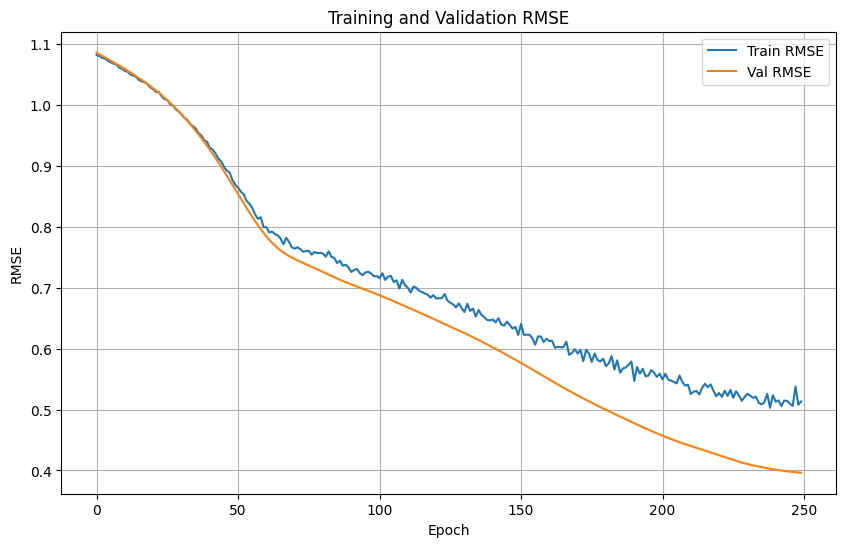

In [11]:
def plot_rmse_history(train_rmse_history, val_rmse_history):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.plot(train_rmse_history, label='Train RMSE')
    plt.plot(val_rmse_history, label='Val RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title('Training and Validation RMSE')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_rmse_history(train_rmse_history, val_rmse_history)

In [12]:
def objective(trial): # the objective function for optuna hyperparameter search
    # Suggest hyperparameters

    lr = trial.suggest_float('lr', 0.0001, 0.01, log=True)
    n_layers = trial.suggest_int('n_layers', 1, 4)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    
    hidden_sizes = [
        trial.suggest_int(f'hidden_size_{i}', 4, 16, 2) for i in range(n_layers)
    ]

    model = MLPRegressor(hidden_sizes, dropout)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.MSELoss()

    for epoch in range(100):  # Reduce epochs for speed
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = loss_function(output, y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = loss_function(val_output, y_val)

    return val_loss.item()

In [13]:
# creating and running the optuna study
study = optuna.create_study(direction='minimize') # minimize because we are using RMSE
study.optimize(objective, n_trials=50)

print("Best params:", study.best_params)
print("Best val loss:", study.best_value)

[I 2025-12-19 21:37:00,441] A new study created in memory with name: no-name-986515e2-6c6b-4e5c-86ee-7a0a512d1446
/tmp/ipykernel_26315/1571926016.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  trial.suggest_int(f'hidden_size_{i}', 4, 16, 2) for i in range(n_layers)
[I 2025-12-19 21:37:00,586] Trial 0 finished with value: 0.9167949557304382 and parameters: {'lr': 0.00021936583592292052, 'n_layers': 2, 'dropout': 0.31731768475023026, 'hidden_size_0': 10, 'hidden_size_1': 10}. Best is trial 0 with value: 0.9167949557304382.
[I 2025-12-19 21:37:00,697] Trial 1 finished with value: 0.3273346722126007 

Best params: {'lr': 0.00966437690286502, 'n_layers': 1, 'dropout': 0.0679314040885545, 'hidden_size_0': 16}
Best val loss: 0.09994331002235413


Epoch 0: train_loss=0.9495, val_loss=0.8400
Epoch 10: train_loss=0.3077, val_loss=0.2352
Epoch 20: train_loss=0.2044, val_loss=0.1894
Epoch 30: train_loss=0.1709, val_loss=0.1549
Epoch 40: train_loss=0.1692, val_loss=0.1485
Epoch 50: train_loss=0.1577, val_loss=0.1405
Epoch 60: train_loss=0.1588, val_loss=0.1369
Epoch 70: train_loss=0.1483, val_loss=0.1295
Epoch 80: train_loss=0.1414, val_loss=0.1264
Epoch 90: train_loss=0.1393, val_loss=0.1211
Epoch 100: train_loss=0.1386, val_loss=0.1161
Epoch 110: train_loss=0.1314, val_loss=0.1112
Epoch 120: train_loss=0.1219, val_loss=0.1055
Epoch 130: train_loss=0.1166, val_loss=0.0968
Epoch 140: train_loss=0.1119, val_loss=0.0884
Epoch 150: train_loss=0.1050, val_loss=0.0806
Epoch 160: train_loss=0.0964, val_loss=0.0746
Epoch 170: train_loss=0.0956, val_loss=0.0715
Epoch 180: train_loss=0.0935, val_loss=0.0682
Epoch 190: train_loss=0.0957, val_loss=0.0679
Epoch 200: train_loss=0.0933, val_loss=0.0668
Epoch 210: train_loss=0.0872, val_loss=0.0658

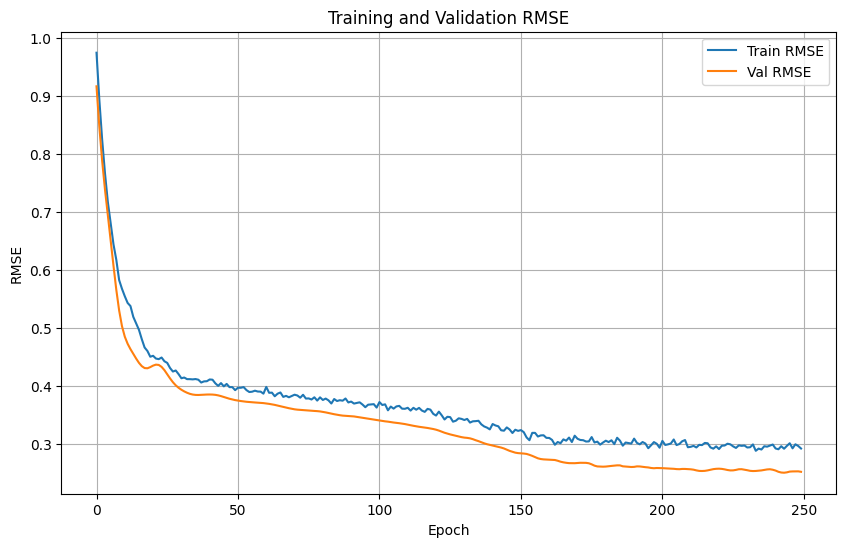

In [14]:
# training the model on the best hyperparameters found

best_params = study.best_params

hidden_sizes = [best_params[f'hidden_size_{i}'] for i in range(best_params['n_layers'])]
dropout_rate = best_params['dropout']
lr = best_params['lr']

train_rmse_history, val_rmse_history = initialize_model_and_train(hidden_sizes, dropout_rate, lr=lr, epochs=250)
plot_rmse_history(train_rmse_history, val_rmse_history)

In [15]:
# Gradient Boosting Regressor

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Convert tensors back to numpy
X_train_gb = X_train.numpy()
X_test_gb  = X_test.numpy()

y_train_gb = y_scaler.inverse_transform(y_train.numpy()).ravel()
y_test_gb  = y_scaler.inverse_transform(y_test.numpy()).ravel()


In [16]:
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train_gb, y_train_gb)


,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [17]:
y_pred_gbr = gbr.predict(X_test_gb)

mse_gbr  = mean_squared_error(y_test_gb, y_pred_gbr)
rmse_gbr = np.sqrt(mse_gbr)
mae_gbr  = mean_absolute_error(y_test_gb, y_pred_gbr)
r2_gbr   = r2_score(y_test_gb, y_pred_gbr)

print("\nGradient Boosting Regressor Results:")
print(f"MSE: {mse_gbr:.4f}")
print(f"RMSE: {rmse_gbr:.4f}")
print(f"MAE: {mae_gbr:.4f}")
print(f"R²: {r2_gbr:.4f}")



Gradient Boosting Regressor Results:
MSE: 5.5609
RMSE: 2.3582
MAE: 1.6563
R²: 0.9409


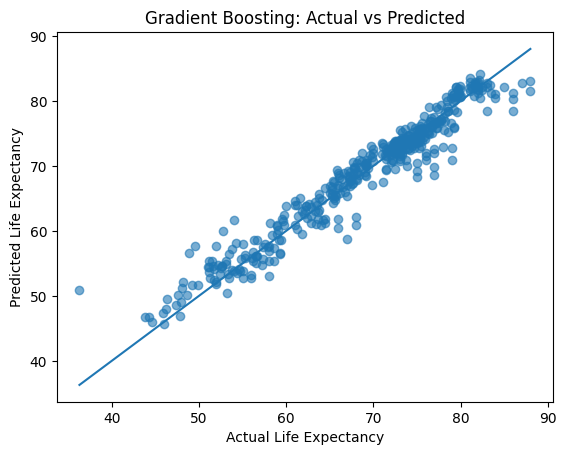

In [18]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_test_gb, y_pred_gbr, alpha=0.6)
plt.plot([y_test_gb.min(), y_test_gb.max()],
         [y_test_gb.min(), y_test_gb.max()])
plt.xlabel("Actual Life Expectancy")
plt.ylabel("Predicted Life Expectancy")
plt.title("Gradient Boosting: Actual vs Predicted")
plt.show()


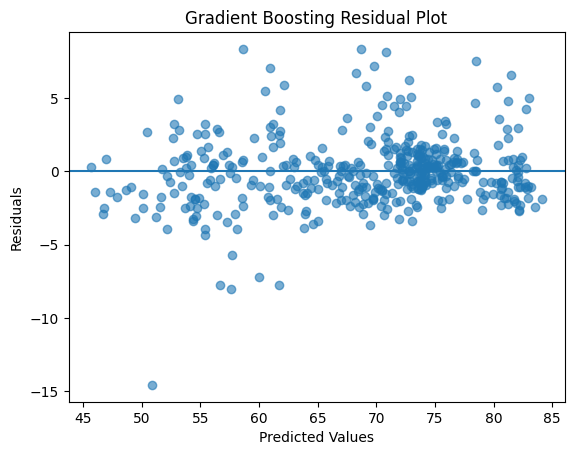

In [19]:
residuals_gbr = y_test_gb - y_pred_gbr

plt.figure()
plt.scatter(y_pred_gbr, residuals_gbr, alpha=0.6)
plt.axhline(0)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Gradient Boosting Residual Plot")
plt.show()
